In [1]:
import sys
sys.path.append('../src')

In [2]:
import pykoopman as pk
import numpy as np
import numpy.random as rnd
np.random.seed(42)  # for reproducibility
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from pykoopman.common import slow_manifold
nonlinear_sys = slow_manifold(mu=-0.1, la=-1.0, dt=0.1)

In [3]:
n_pts = 51
xmin = ymin = -2
xmax = ymax = +2
xx, yy = np.meshgrid(np.linspace(xmin, xmax, n_pts), np.linspace(ymin, ymax, n_pts))
Xdat = np.vstack((xx.flatten(), yy.flatten()))

In [4]:
max_n_int = 51

traj_list = []
for i in range(Xdat.shape[1]):
    X, Y = nonlinear_sys.collect_data_discrete(Xdat[:,[i]], np.random.randint(1, max_n_int))
    tmp = np.hstack([X, Y[:,-1:]]).T
    traj_list.append(tmp)

Text(0.5, 1.0, 'we can handle trajectory data with varying-length sequence!')

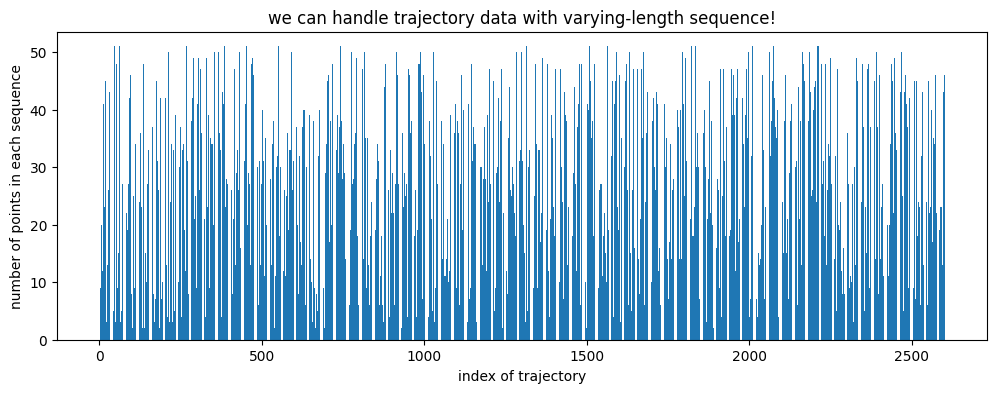

In [5]:
plt.figure(figsize=(12,4))
plt.bar(np.arange(len(traj_list)), [len(x) for x in traj_list])
plt.xlabel('index of trajectory')
plt.ylabel('number of points in each sequence')
plt.title('we can handle trajectory data with varying-length sequence!')

In [5]:
look_forward = 50
dlk_regressor = pk.regression.NNDMD(dt=nonlinear_sys.dt, look_forward=look_forward,
                                    config_encoder=dict(input_size=2,
                                                        hidden_sizes=[32] * 3,
                                                        output_size=3,
                                                        activations="swish"),
                                    config_decoder=dict(input_size=3, hidden_sizes=[],
                                                        output_size=2, activations="linear"),
                                    batch_size=512, lbfgs=True,
                                    normalize=True, normalize_mode='equal',
                                    normalize_std_factor=1.0,
                                    trainer_kwargs=dict(max_epochs=3))

In [6]:
dlk_regressor.fit(traj_list)

INFO: GPU available: False, used: False
[rank_zero.py:63 -                _info() ] GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
[rank_zero.py:63 -                _info() ] TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
[rank_zero.py:63 -                _info() ] IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
[rank_zero.py:63 -                _info() ] HPU available: False, using: 0 HPUs
INFO: 
  | Name                | Type                    | Params
----------------------------------------------------------------
0 | _encoder            | FFNN                    | 2.3 K 
1 | _decoder            | FFNN                    | 6     
2 | _koopman_propagator | StandardKoopmanOperator | 9     
3 | masked_loss_metric  | MaskedMSELoss           | 0     
----------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total 

Epoch 2: 100%|█| 6/6 [00:10<00:00,  1.72s/it, v_num=2, loss=1.25e-6, rec_loss=4.

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
[rank_zero.py:63 -                _info() ] `Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|█| 6/6 [00:10<00:00,  1.73s/it, v_num=2, loss=1.25e-6, rec_loss=4.


In [7]:
eigv = np.log(dlk_regressor.eigenvalues_)/nonlinear_sys.dt
print(eigv)

[-0.9996435  -0.09993793 -0.1997281 ]


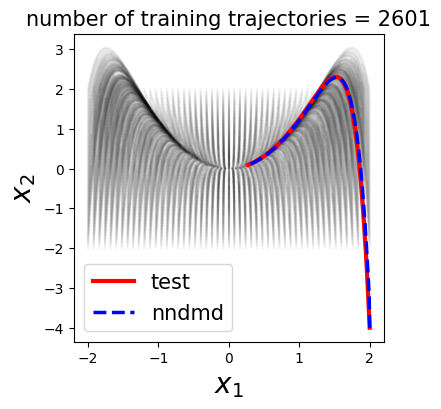

In [10]:
# Testing on unseen trajectory
plt.figure(figsize=(4,4))
for i in range(len(traj_list)):
    plt.plot(traj_list[i][:,0],traj_list[i][:,1],'-k',alpha=0.05)
plt.plot(Xtest[:,0],Xtest[:,1],'-r',lw=3,label='test')
plt.plot(Xkoop_nn[:,0],Xkoop_nn[:,1],'--b',lw=2.5,label='nndmd')

plt.xlabel(r"$x_1$",size=20)
plt.ylabel(r"$x_2$",size=20)
plt.title(f"number of training trajectories = {len(traj_list)}",size=15)
plt.legend(loc='best',fontsize=15)

x0 = np.array([2, -4])  #np.array([2, -4])
T = 20
t = np.arange(0, T, nonlinear_sys.dt)
Xtest = nonlinear_sys.simulate(x0[:, np.newaxis], len(t)-1).T
Xtest = np.vstack([x0[np.newaxis, :], Xtest])

Xkoop_nn = dlk_regressor.simulate(x0[np.newaxis, :], n_steps=len(t)-1)

In [11]:
# create some grid
n_pts = 501
xmin = ymin = -2
xmax = ymax = +2
xx, yy = np.meshgrid(np.linspace(xmin, xmax, n_pts), np.linspace(ymin, ymax, n_pts))
Xdat = np.vstack((xx.flatten(), yy.flatten()))


In [12]:
# compute the transformation (real numbers)
transf = dlk_regressor._compute_phi(Xdat)

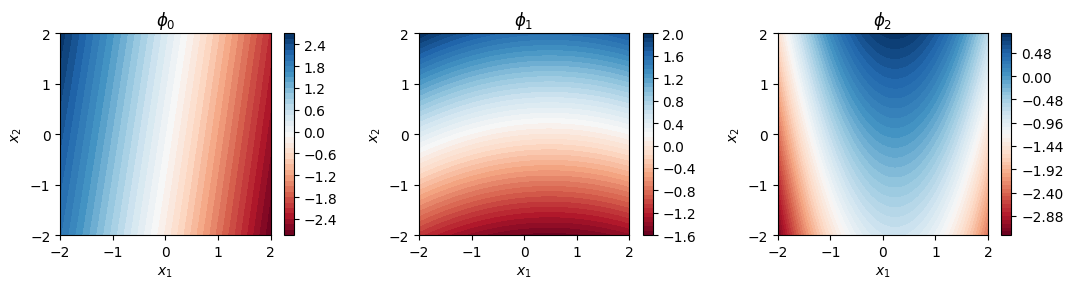

In [13]:
fig,axs=plt.subplots(1,3,figsize=(11,3))
for i in range(3):
    im = axs[i].contourf(xx,yy,transf[i].reshape(n_pts, n_pts),cmap='RdBu',levels=50)
    axs[i].set_title(f"$\phi_{i}$")
    axs[i].set_xlabel(r"$x_1$")
    axs[i].set_ylabel(r"$x_2$")
    fig.colorbar(im,ax=axs[i])
plt.tight_layout()

In [14]:
# create some grid
n_pts = 501
xmin = ymin = -2
xmax = ymax = +2
xx, yy = np.meshgrid(np.linspace(xmin,xmax, n_pts), np.linspace(ymin, ymax, n_pts))
Xdat = np.vstack((xx.flatten(), yy.flatten()))


In [15]:
# compute the eigenfunction
eigf = dlk_regressor._compute_psi(Xdat)

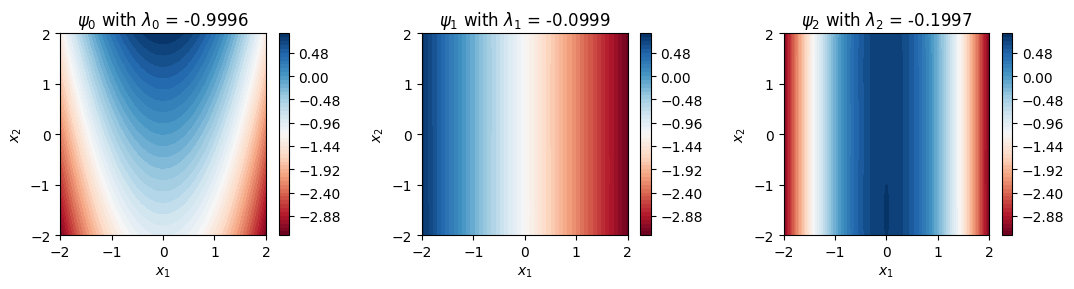

In [16]:
fig,axs=plt.subplots(1,3,figsize=(11,3))
for i in range(3):
    axs[i].contourf(xx,yy,eigf[i].reshape(n_pts, n_pts),cmap='RdBu',levels=50)
    axs[i].set_title(f"$\psi_{i}$ with $\lambda_{i}$ = {eigv[i]:.4f}")
    axs[i].set_xlabel(r"$x_1$")
    axs[i].set_ylabel(r"$x_2$")
    fig.colorbar(im,ax=axs[i])
plt.tight_layout()

In [17]:
# just consider random state x, let's verify we can get x back
x = np.random.rand(100,2)*2-1
phi = dlk_regressor.phi(x_col=x.T)
x_rec = dlk_regressor.C @ phi

# verification using 0.1% deviation error as criterion
assert np.linalg.norm(x_rec-x.T)/np.linalg.norm(x) < 1e-2


In [18]:
x = np.random.rand(100,2)*2-1
psi = dlk_regressor.psi(x_col=x.T)
x_rec = dlk_regressor.W  @ psi

# verification using 0.1% deviation error as criterion
assert np.linalg.norm(x_rec-x.T)/np.linalg.norm(x) < 1e-2